# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data import gen_pseudo_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [ ]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [ ]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [ ]:
domain = "weblogs"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [ ]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 1016
The number of tags 47
The number of samples: 1015
The number of tags 49
after filter tag 1016
after filter tag 974


In [ ]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Scratch_fixed_self_learning")

In [ ]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [ ]:
loop_i = 0
top_percent = 0.1

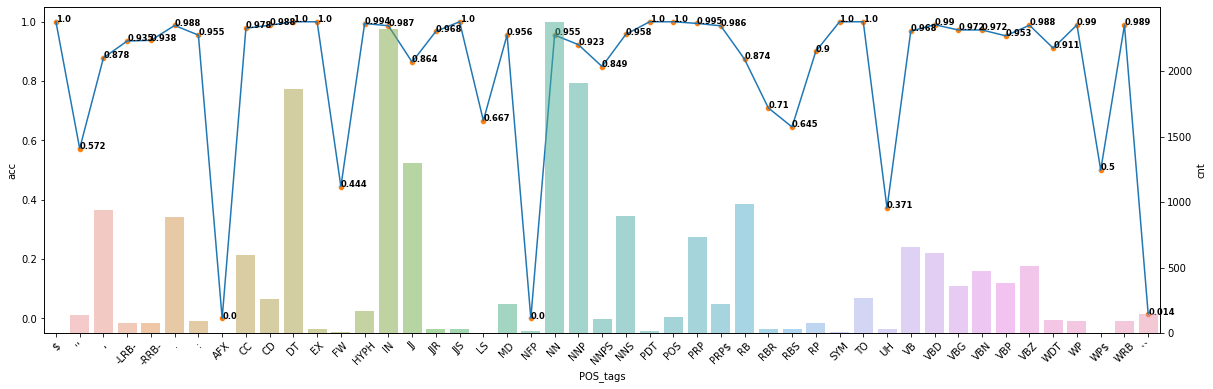

In [ ]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)


The number of sentences in top n 101

Loop 1
domain_dev_word_lst 1016


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9615426063537598
step: 10, loss: 2.028738021850586
step: 20, loss: 0.9401451945304871
step: 30, loss: 0.39022526144981384
step: 40, loss: 0.31848371028900146
step: 50, loss: 0.16680754721164703
step: 60, loss: 0.4329555630683899
step: 70, loss: 0.10017356276512146
step: 80, loss: 0.32024842500686646
step: 90, loss: 0.15666815638542175
step: 100, loss: 0.11064953356981277
step: 110, loss: 0.227885439991951
step: 120, loss: 0.1769273579120636
step: 130, loss: 0.18119506537914276
step: 140, loss: 0.18986056745052338
step: 150, loss: 0.20624905824661255
step: 160, loss: 0.12922631204128265
step: 170, loss: 0.11267612129449844
step: 180, loss: 0.11182031035423279
step: 190, loss: 0.2514446973800659
step: 200, loss: 0.10553291440010071
step: 210, loss: 0.08069007098674774
step: 220, loss: 0.11590555310249329
step: 230, loss: 0.10394406318664551
step: 240, loss: 0.07200505584478378
step: 250, loss: 0.07417535781860352
step: 260, loss: 0.1334965080022812


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.967670202255249
step: 10, loss: 1.9612889289855957
step: 20, loss: 0.7045705914497375
step: 30, loss: 0.36796027421951294
step: 40, loss: 0.23272381722927094
step: 50, loss: 0.167508065700531
step: 60, loss: 0.2893401086330414
step: 70, loss: 0.20066672563552856
step: 80, loss: 0.17738698422908783
step: 90, loss: 0.15335215628147125
step: 100, loss: 0.24655881524085999
step: 110, loss: 0.1402599811553955
step: 120, loss: 0.06263302266597748
step: 130, loss: 0.24714240431785583
step: 140, loss: 0.20124882459640503
step: 150, loss: 0.10985514521598816
step: 160, loss: 0.14932754635810852
step: 170, loss: 0.10102695971727371
step: 180, loss: 0.19047823548316956
step: 190, loss: 0.223471537232399
step: 200, loss: 0.17076343297958374
step: 210, loss: 0.12966401875019073
step: 220, loss: 0.19936959445476532
step: 230, loss: 0.0733778327703476
step: 240, loss: 0.11210652440786362
step: 250, loss: 0.10140205919742584
step: 260, loss: 0.19768978655338287
s

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.881223440170288
step: 10, loss: 2.216806411743164
step: 20, loss: 0.8366820812225342
step: 30, loss: 0.2503756880760193
step: 40, loss: 0.33423125743865967
step: 50, loss: 0.3550035357475281
step: 60, loss: 0.10935485363006592
step: 70, loss: 0.15453144907951355
step: 80, loss: 0.1861613541841507
step: 90, loss: 0.18927809596061707
step: 100, loss: 0.11572108417749405
step: 110, loss: 0.11679533123970032
step: 120, loss: 0.08824679255485535
step: 130, loss: 0.23176074028015137
step: 140, loss: 0.11286724358797073
step: 150, loss: 0.14449681341648102
step: 160, loss: 0.17038318514823914
step: 170, loss: 0.15634316205978394
step: 180, loss: 0.17698170244693756
step: 190, loss: 0.16947737336158752
step: 200, loss: 0.09767936170101166
step: 210, loss: 0.15515293180942535
step: 220, loss: 0.07785103470087051
step: 230, loss: 0.045893024653196335
step: 240, loss: 0.10439752787351608
step: 250, loss: 0.28008320927619934
step: 260, loss: 0.086295939981937

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9540534019470215
step: 10, loss: 2.0156404972076416
step: 20, loss: 0.9013091921806335
step: 30, loss: 0.4794580638408661
step: 40, loss: 0.3979648947715759
step: 50, loss: 0.22627633810043335
step: 60, loss: 0.1385287344455719
step: 70, loss: 0.23135173320770264
step: 80, loss: 0.2116079032421112
step: 90, loss: 0.16169272363185883
step: 100, loss: 0.2296309918165207
step: 110, loss: 0.15251170098781586
step: 120, loss: 0.22521348297595978
step: 130, loss: 0.16294173896312714
step: 140, loss: 0.18941889703273773
step: 150, loss: 0.11262828856706619
step: 160, loss: 0.15296223759651184
step: 170, loss: 0.08908579498529434
step: 180, loss: 0.0885031521320343
step: 190, loss: 0.12870511412620544
step: 200, loss: 0.202964186668396
step: 210, loss: 0.24882610142230988
step: 220, loss: 0.14870186150074005
step: 230, loss: 0.06582082808017731
step: 240, loss: 0.22587959468364716
step: 250, loss: 0.06800572574138641
step: 260, loss: 0.06885819882154465
s

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9386227130889893
step: 10, loss: 2.0302164554595947
step: 20, loss: 0.8566992878913879
step: 30, loss: 0.33618298172950745
step: 40, loss: 0.3518312871456146
step: 50, loss: 0.16233384609222412
step: 60, loss: 0.18611964583396912
step: 70, loss: 0.1356026530265808
step: 80, loss: 0.13688115775585175
step: 90, loss: 0.17645734548568726
step: 100, loss: 0.10035037249326706
step: 110, loss: 0.18308348953723907
step: 120, loss: 0.1801804155111313
step: 130, loss: 0.22181522846221924
step: 140, loss: 0.23806531727313995
step: 150, loss: 0.18093711137771606
step: 160, loss: 0.21247459948062897
step: 170, loss: 0.166415274143219
step: 180, loss: 0.08403083682060242
step: 190, loss: 0.1252099573612213
step: 200, loss: 0.12297679483890533
step: 210, loss: 0.08517740666866302
step: 220, loss: 0.18470428884029388
step: 230, loss: 0.11867669224739075
step: 240, loss: 0.07584135979413986
step: 250, loss: 0.10138065367937088
step: 260, loss: 0.04496673494577408

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.980506420135498
step: 10, loss: 1.756134033203125
step: 20, loss: 0.6343501806259155
step: 30, loss: 0.29258081316947937
step: 40, loss: 0.3252047598361969
step: 50, loss: 0.2530793249607086
step: 60, loss: 0.2567998468875885
step: 70, loss: 0.15777122974395752
step: 80, loss: 0.12204945832490921
step: 90, loss: 0.1377103626728058
step: 100, loss: 0.09412478655576706
step: 110, loss: 0.15244494378566742
step: 120, loss: 0.23438458144664764
step: 130, loss: 0.1780579388141632
step: 140, loss: 0.08366745710372925
step: 150, loss: 0.08715923875570297
step: 160, loss: 0.0762069821357727
step: 170, loss: 0.18046313524246216
step: 180, loss: 0.06916564702987671
step: 190, loss: 0.10871237516403198
step: 200, loss: 0.10457020998001099
step: 210, loss: 0.10173869878053665
step: 220, loss: 0.18937183916568756
step: 230, loss: 0.30805933475494385
step: 240, loss: 0.14686574041843414
step: 250, loss: 0.07569831609725952
step: 260, loss: 0.1591910719871521
st

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.955805540084839
step: 10, loss: 2.1460063457489014
step: 20, loss: 0.7102858424186707
step: 30, loss: 0.32873663306236267
step: 40, loss: 0.3560338318347931
step: 50, loss: 0.32450026273727417
step: 60, loss: 0.20894849300384521
step: 70, loss: 0.30629968643188477
step: 80, loss: 0.2992727756500244
step: 90, loss: 0.19363166391849518
step: 100, loss: 0.16657572984695435
step: 110, loss: 0.19614489376544952
step: 120, loss: 0.3042203187942505
step: 130, loss: 0.10184002667665482
step: 140, loss: 0.09124044328927994
step: 150, loss: 0.19031640887260437
step: 160, loss: 0.057671915739774704
step: 170, loss: 0.138071671128273
step: 180, loss: 0.059776872396469116
step: 190, loss: 0.19195599853992462
step: 200, loss: 0.13812324404716492
step: 210, loss: 0.13010409474372864
step: 220, loss: 0.0655614361166954
step: 230, loss: 0.2257373183965683
step: 240, loss: 0.07684113085269928
step: 250, loss: 0.16213476657867432
step: 260, loss: 0.08767027407884598

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 4.069949150085449
step: 10, loss: 1.8713260889053345
step: 20, loss: 0.5066182017326355
step: 30, loss: 0.37629202008247375
step: 40, loss: 0.41161906719207764
step: 50, loss: 0.13678032159805298
step: 60, loss: 0.14890097081661224
step: 70, loss: 0.09250044822692871
step: 80, loss: 0.118000328540802
step: 90, loss: 0.22218582034111023
step: 100, loss: 0.06256075948476791
step: 110, loss: 0.15892811119556427
step: 120, loss: 0.07924316823482513
step: 130, loss: 0.1537867933511734
step: 140, loss: 0.12570039927959442
step: 150, loss: 0.21604490280151367
step: 160, loss: 0.15501338243484497
step: 170, loss: 0.05519009754061699
step: 180, loss: 0.13419483602046967
step: 190, loss: 0.13072502613067627
step: 200, loss: 0.19979645311832428
step: 210, loss: 0.09942363947629929
step: 220, loss: 0.19842644035816193
step: 230, loss: 0.20901651680469513
step: 240, loss: 0.16559089720249176
step: 250, loss: 0.07584041357040405
step: 260, loss: 0.180646628141403

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.8699731826782227
step: 10, loss: 2.0270142555236816
step: 20, loss: 0.680743932723999
step: 30, loss: 0.4408862292766571
step: 40, loss: 0.3278777301311493
step: 50, loss: 0.29144465923309326
step: 60, loss: 0.17995919287204742
step: 70, loss: 0.18048658967018127
step: 80, loss: 0.1659056693315506
step: 90, loss: 0.23929034173488617
step: 100, loss: 0.18434646725654602
step: 110, loss: 0.15789437294006348
step: 120, loss: 0.1118568480014801
step: 130, loss: 0.17409837245941162
step: 140, loss: 0.08564264327287674
step: 150, loss: 0.22666816413402557
step: 160, loss: 0.07909280061721802
step: 170, loss: 0.13959400355815887
step: 180, loss: 0.1150016114115715
step: 190, loss: 0.340962290763855
step: 200, loss: 0.1376791149377823
step: 210, loss: 0.0708760917186737
step: 220, loss: 0.2034645527601242
step: 230, loss: 0.10988770425319672
step: 240, loss: 0.18590986728668213
step: 250, loss: 0.16929052770137787
step: 260, loss: 0.04572385922074318
step

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.910829544067383
step: 10, loss: 1.9750425815582275
step: 20, loss: 0.8260322213172913
step: 30, loss: 0.4474089443683624
step: 40, loss: 0.34978166222572327
step: 50, loss: 0.2579375207424164
step: 60, loss: 0.2642775774002075
step: 70, loss: 0.19669117033481598
step: 80, loss: 0.14369092881679535
step: 90, loss: 0.2425267994403839
step: 100, loss: 0.11310980468988419
step: 110, loss: 0.09490054100751877
step: 120, loss: 0.2268376648426056
step: 130, loss: 0.16375534236431122
step: 140, loss: 0.09207221120595932
step: 150, loss: 0.16374067962169647
step: 160, loss: 0.1147996187210083
step: 170, loss: 0.08775930106639862
step: 180, loss: 0.08196656405925751
step: 190, loss: 0.1289936900138855
step: 200, loss: 0.1357191950082779
step: 210, loss: 0.1653180569410324
step: 220, loss: 0.1336999088525772
step: 230, loss: 0.09613099694252014
step: 240, loss: 0.20170995593070984
step: 250, loss: 0.1576402485370636
step: 260, loss: 0.1323903352022171
step: 

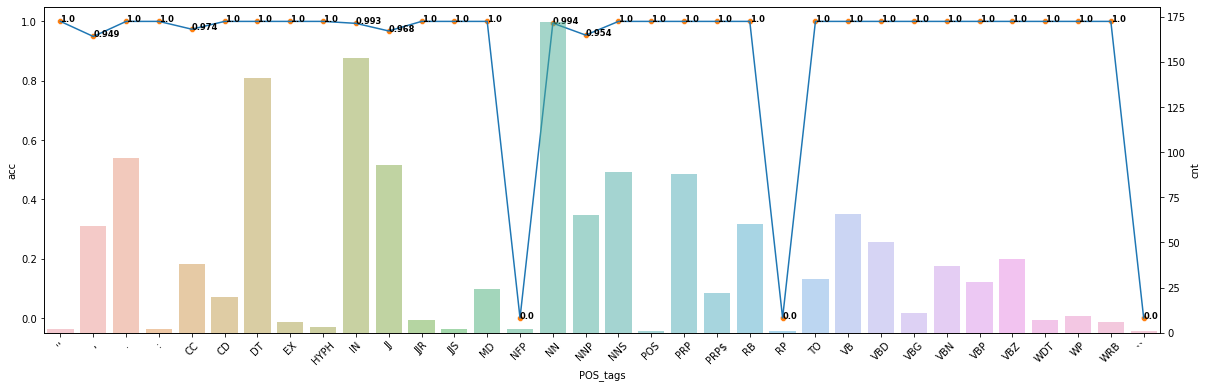

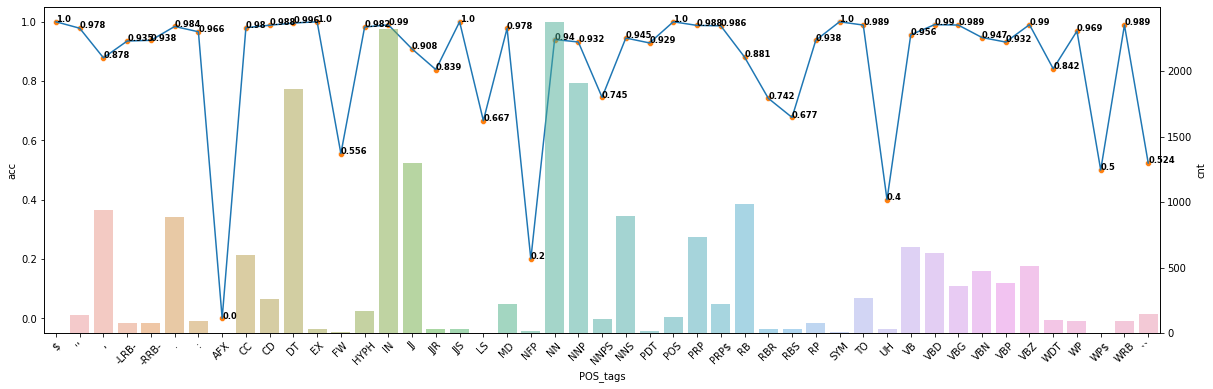

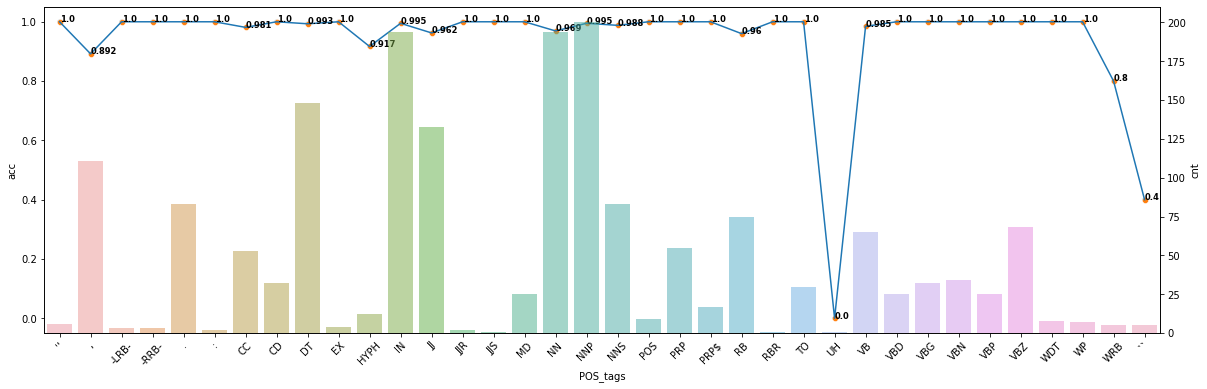

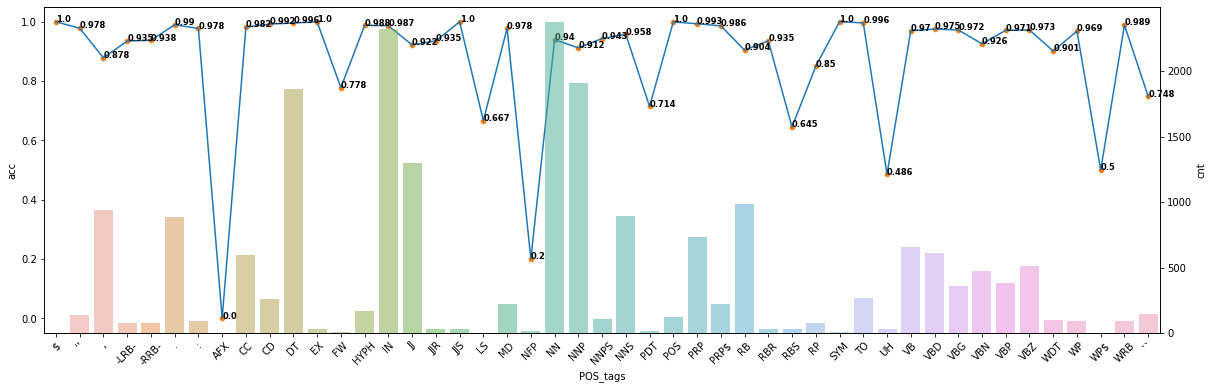

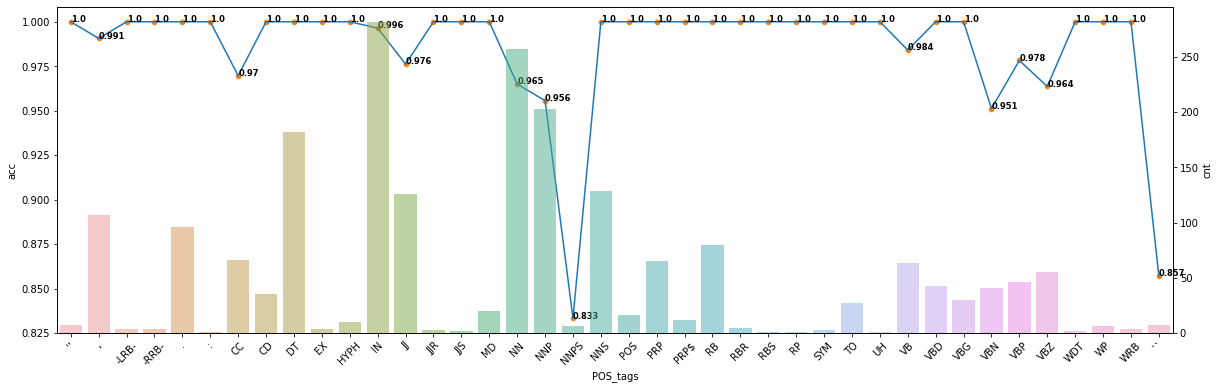

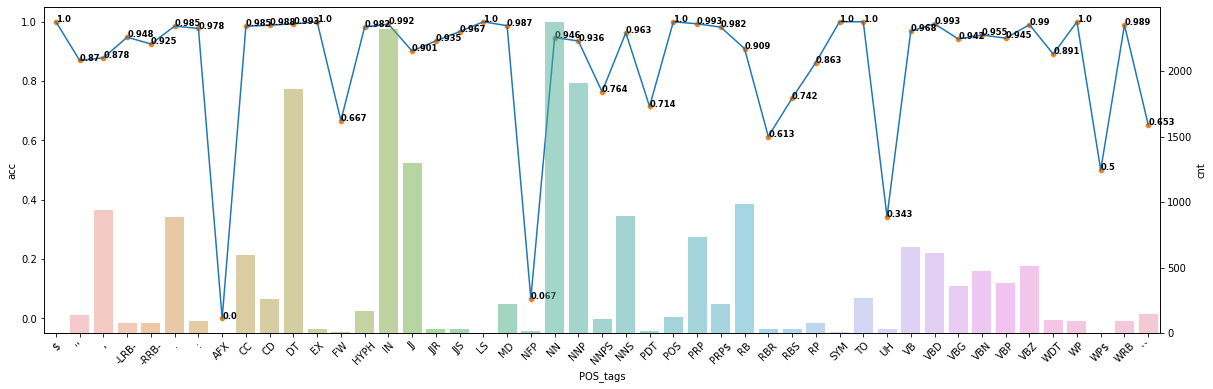

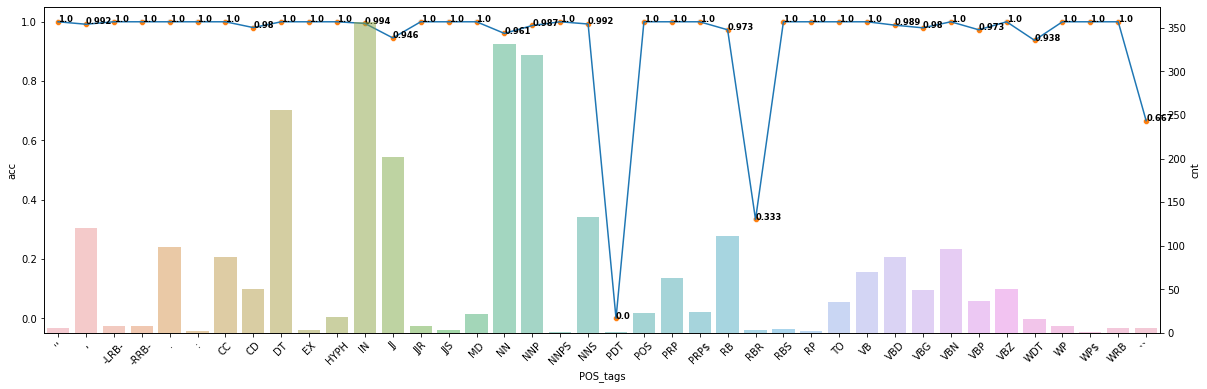

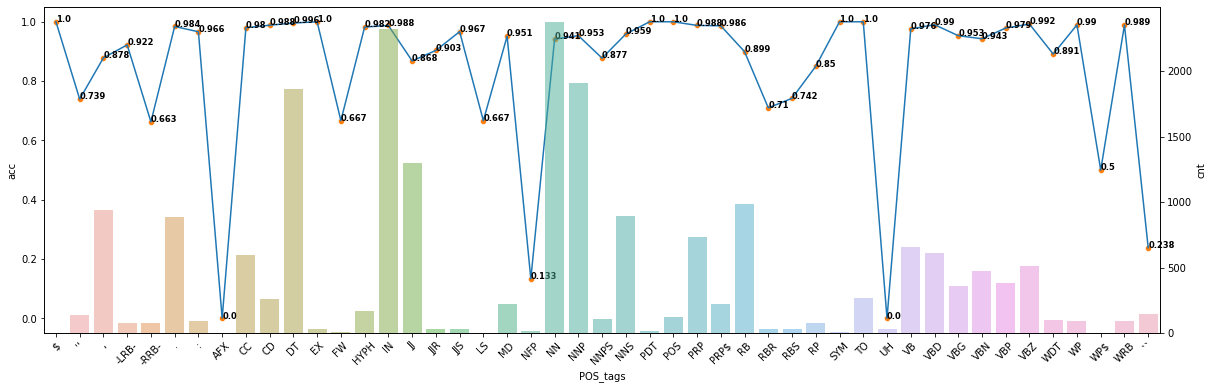

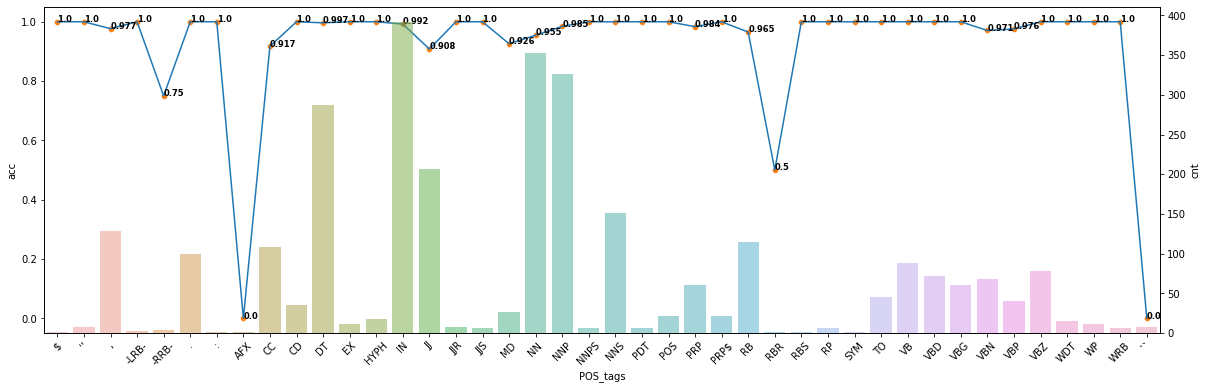

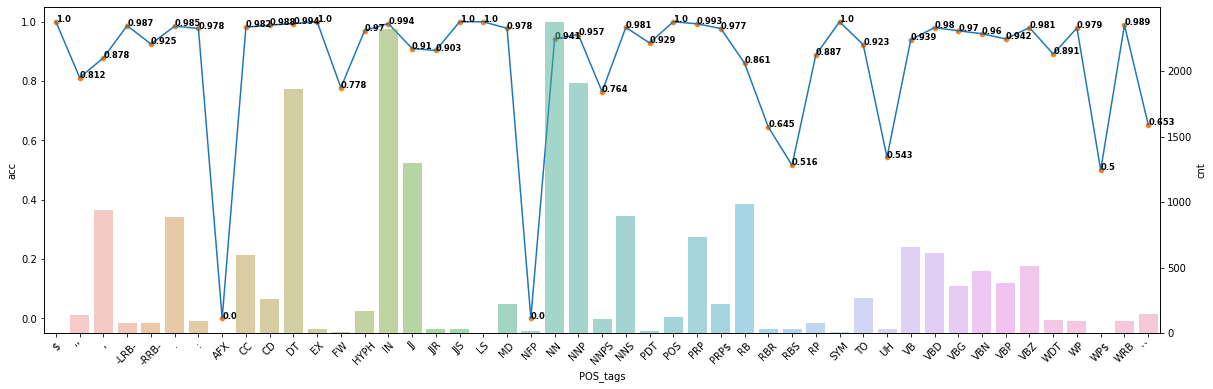

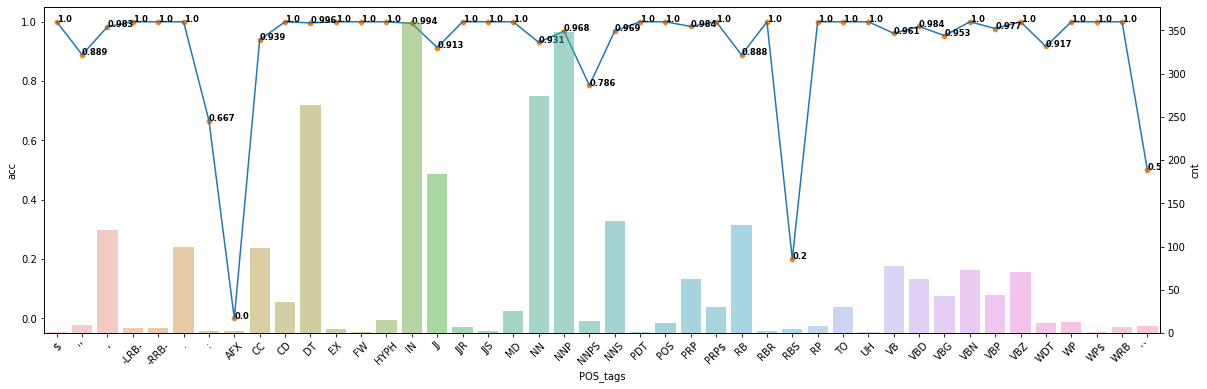

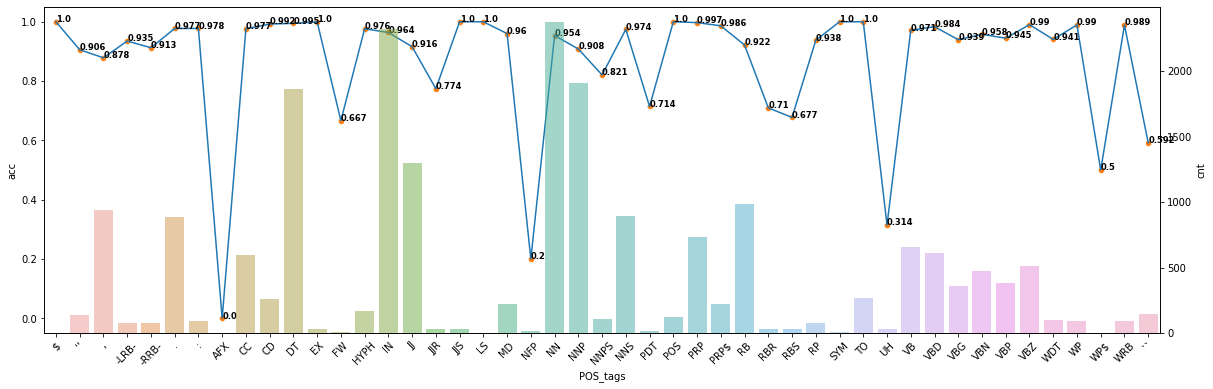

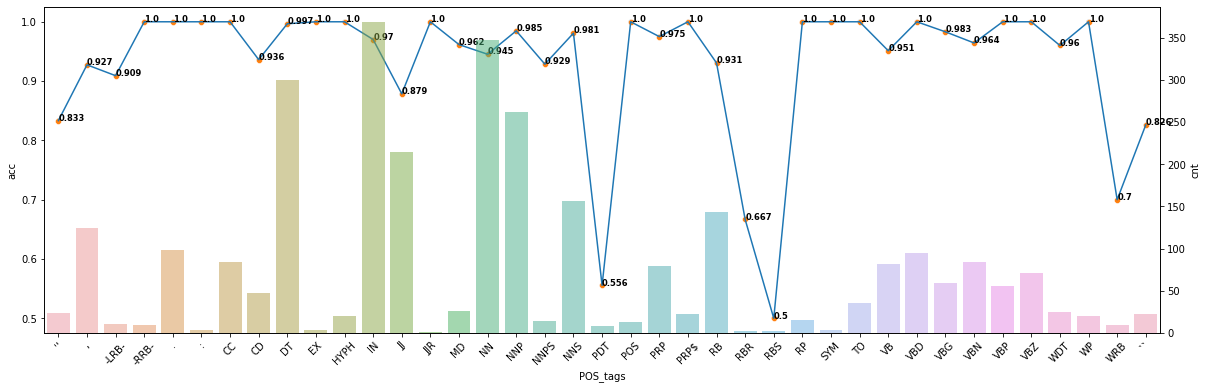

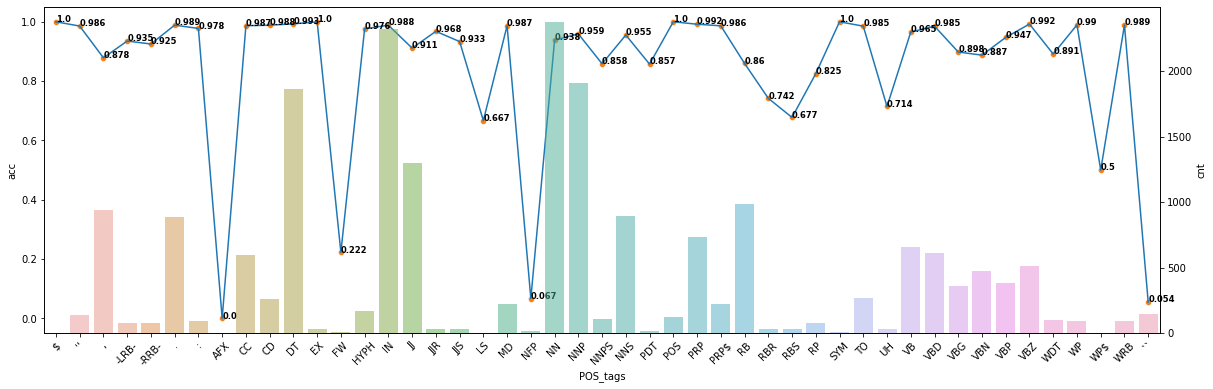

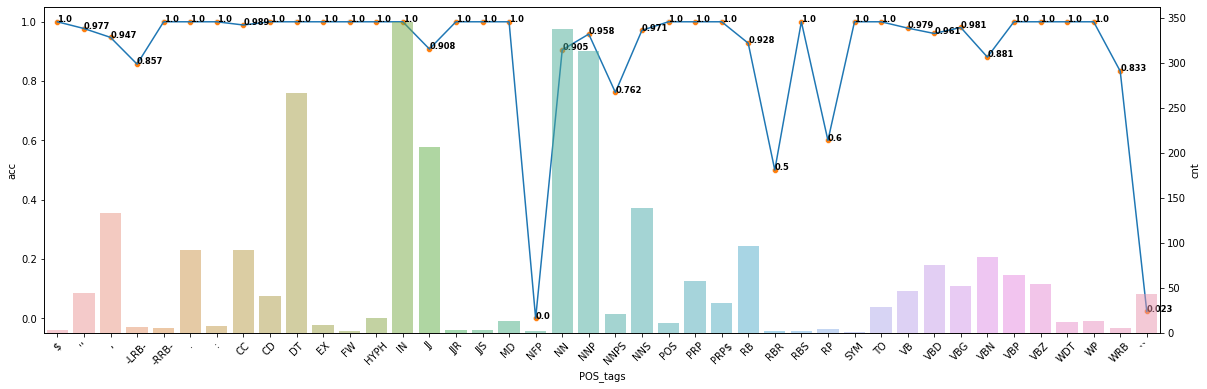

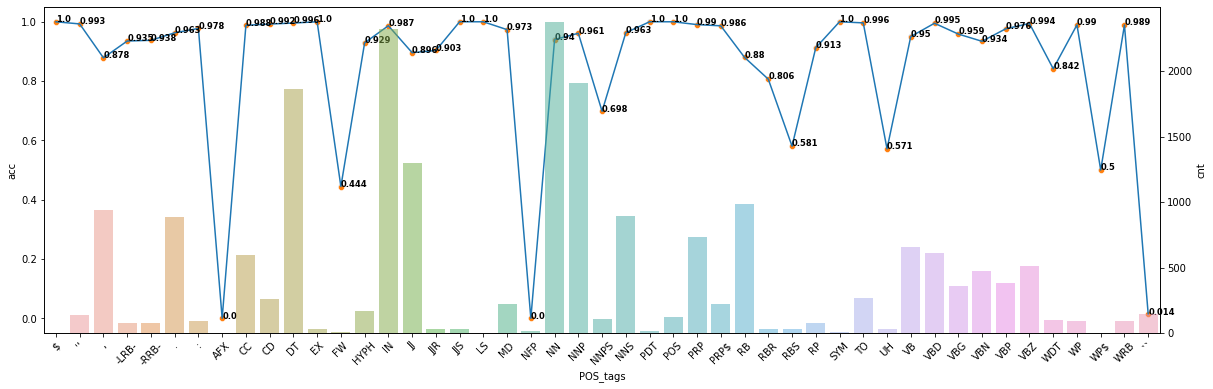

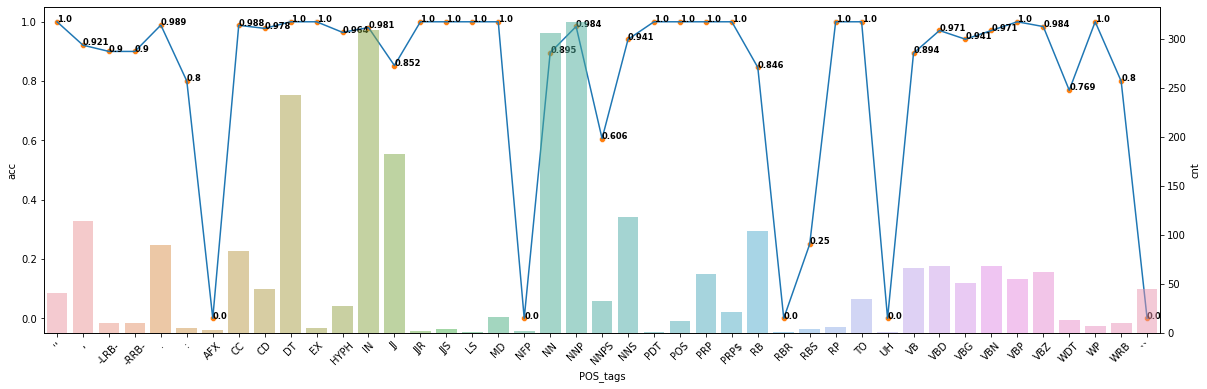

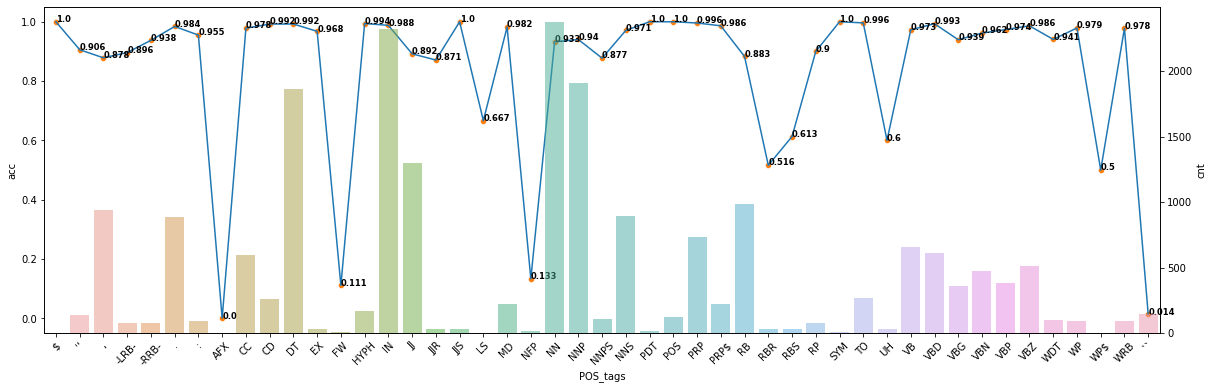

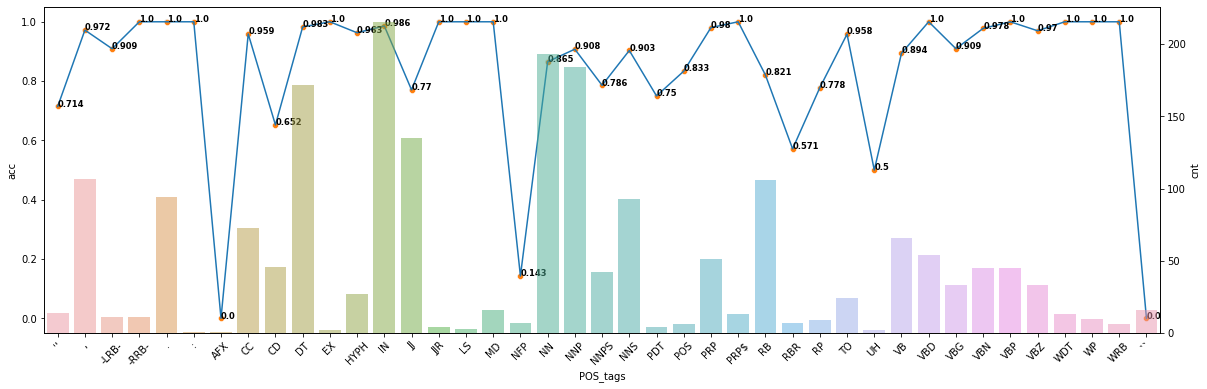

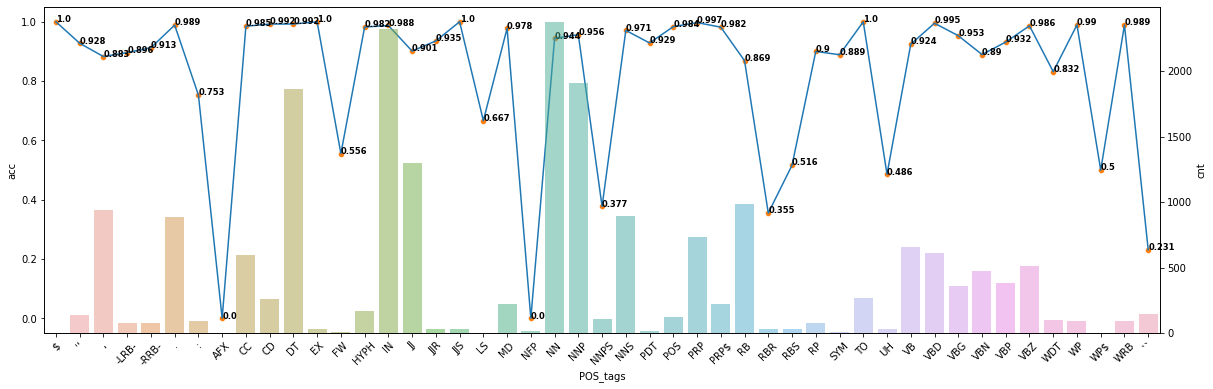

In [ ]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))
print("The number of sentences in top n", topn)

while len(domain_dev_word_lst) >= topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)
  
  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{top_percent}-loop{loop_i}.txt")

  (top_words, top_tags, top_pseudo_tags, top_prob, top_acc, remain_words, 
   remain_tags, remain_pseudo_tags, remain_prob, remain_acc)= gen_pseudo_data(
       model, domain_dev_iter, topn, save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)

  new_train_dataset = PosDataset(
      wsj_train_word_lst + top_words, 
      wsj_train_tag_lst + top_pseudo_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)
  
  print("Train from scratch...")
  model = Net(vocab_size=len(TAG2IDX))
  model.to(DEVICE)
  model = nn.DataParallel(model)

  optimizer = optim.Adam(model.parameters(), lr = 0.0001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)

  domain_dev_word_lst = remain_words
  domain_dev_tag_lst = remain_tags

  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  acc_lst.append(top_acc)
  prob_lst.append(top_prob)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)


In [ ]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [ ]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [ ]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [ ]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)